In [1]:
import numpy as np
import dynet_config
dynet_config.set(
    mem=2048,          # can probably get away with 1024
    autobatch=True,    # utilize autobatching
    random_seed=1978   # simply for reproducibility here
)
import dynet as dy

# `dyNet` example: `spam` v. `ham`

In [2]:
dy.__version__

2.0

## import features

In [3]:
import sys
sys.path.append("..")
import utils as u

In [4]:
# change this string to match the path on your computer
path_to_root = "/Users/mcapizzi/Github/dynet_tutorial/"

In [5]:
trainX, trainY, testX, testY = u.import_data(path_to_root)

loading training data
loading test data


In [6]:
trainX.shape, trainY.shape

((953, 2955), (953,))

In [7]:
testX.shape, testY.shape

((105, 2955), (105,))

The labels are either `1` or `0` where `1=Spam` and `0=Ham`

In [8]:
testY

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1])

The data is a `matrix` where each `row` is a document, and each `column` is a "transformed" count of how many times each word in the vocabulary appeared in that document.

In [9]:
np.nonzero(testX[23])

(array([   0,   77,   93,  114,  117,  151,  229,  233,  239,  260,  301,
         303,  316,  343,  379,  412,  441,  466,  553,  562,  574,  612,
         622,  627,  679,  870,  962,  964, 1002, 1060, 1083, 1094, 1116,
        1128, 1137, 1139, 1204, 1224, 1258, 1261, 1290, 1365, 1366, 1384,
        1400, 1408, 1475, 1478, 1531, 1548, 1625, 1643, 1685, 1748, 1751,
        1780, 1794, 1803, 1867, 1919, 1944, 2032, 2040, 2120, 2146, 2153,
        2234, 2269, 2337, 2345, 2361, 2366, 2384, 2421, 2427, 2450, 2460,
        2487, 2496, 2526, 2547, 2552, 2575, 2599, 2621, 2627, 2670, 2682,
        2690, 2765, 2790, 2792, 2812, 2855, 2887, 2921, 2925]),)

In [10]:
trainX[23][77]

0.00042789901583226359

## build architecture
all images borrowed from here: http://u.cs.biu.ac.il/~yogo/nnlp.pdf (now a book!)

![goldberg_nn](images/goldberg_ff.png)

![goldberg_ff_math](images/goldberg_ff_math.png)

### initialize empty model

See http://dynet.readthedocs.io/en/latest/python_ref.html#parametercollection

The first thing to be done is initialize the `ParameterCollection()` which will house all the parameters that will be updated during training.

In [11]:
feed_forward_model = dy.ParameterCollection()   # used to be called dy.Model()
feed_forward_model

### dimensions

You have a decision on what size you want the `hidden` layer to be.

![goldberg_math_simple](images/goldberg_ff_math_simple.png)

In [12]:
# size of input (2955)
input_size = trainX.shape[1]
################
# HYPERPARAMETER
################
# size of hidden layer
hidden_size = 200

#### paramater `initializer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#parameters-initializers

Next we need to "initialize" the parameter values.  `GlorotInitializer` is a pretty standard approach *however* the `gain` parameter depends on the type of `activation` being used.

In [13]:
################
# HYPERPARAMETER
################
initializer = dy.GlorotInitializer(gain=4.0)

You'll notice that the objects are `_dynet.Parameters` and *not* `expressions` until you "wrap" them with `dy.parameter()`

In [14]:
# W_1 (input x hidden) as a Parameters object
pW_1 = feed_forward_model.add_parameters(
    (input_size, hidden_size),
    init=initializer
)
type(pW_1), type(dy.parameter(pW_1))

(_dynet.Parameters, _dynet.Expression)

In [15]:
# check the shape of the Expression
dy.parameter(pW_1).npvalue().shape

(2955, 200)

In [16]:
# b_1 (1 x hidden) as a Parameters object
pb_1 = feed_forward_model.add_parameters(
    (1, hidden_size),
    init=initializer
)
# check the shape
dy.parameter(pb_1).npvalue().shape

(1, 200)

In [17]:
# W_2 (hidden x output) as a Parameters object
pW_2 = feed_forward_model.add_parameters(
    (hidden_size, 1),
    init=initializer
)
# check the shape
dy.parameter(pW_2).npvalue().shape

(200, 1)

In [18]:
# b_2 (1 x output) as a Paramters object
pb_2 = feed_forward_model.add_parameters(
    (1, 1),
    init=initializer
)
# check the shape
dy.parameter(pb_2).npvalue().shape

(1, 1)

### forward operations
![goldberg_math_simple](images/goldberg_ff_math_simple.png)

The only real choice is the type of `activation`.  See here for your choices: http://dynet.readthedocs.io/en/latest/operations.html

In [19]:
def forward_pass(x):
    """
    This function will wrap all the steps of the forward pass
    :param x: the input
    """
    # convert input to Expression (this step must happen here b/c of autobatching)
    x = dy.inputTensor(x)
    # convert Parameters to Expressions
    W_1 = dy.parameter(pW_1)
    b_1 = dy.parameter(pb_1)
    W_2 = dy.parameter(pW_2)
    b_2 = dy.parameter(pb_2)
    # calculate the first hidden layer
    hidden = x * W_1 + b_1          
    ################
    # HYPERPARAMETER
    ################
    # calculate the sigmoid activation  (or RELU, SELU, ELU, tanh, etc...)
    hidden_activation = dy.logistic(hidden)    
    # calculate the output layer
    output = hidden_activation * W_2 + b_2
    # return the sigmoid of the output
    return dy.logistic(output)

### training

#### initializing a `trainer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#optimizers

This decision is a big one.  It relates to what "optimizer" will be used to update the parameters.  Here I've chosen a *very simple* `trainer`, however the default `learning_rate` is almost never a good one.

In [20]:
################
# HYPERPARAMETER
################
trainer = dy.SimpleSGDTrainer(
    m=feed_forward_model,
    learning_rate=0.01
)

### autobatching
See http://dynet.readthedocs.io/en/latest/minibatch.html#

This is one of the real advantages of `dyNet`.  It's "overkill" for this example, but will become hugely valuable when training `recurrent neural networks` (`RNNs`).

In [21]:
import dynet_config
dynet_config.set(
    mem=2048,          # can probably get away with 1024
    autobatch=True,    # utilize autobatching
    random_seed=1978   # simply for reproducibility here
)
import dynet as dy

#### one `epoch`

Let's walk through *one* epoch (where our model sees all of our data *one* time).

The most important step is `dy.renew_cg()` which starts off a "clean" computational graph.


In [22]:
# store original values of W_1
original_W1 = dy.parameter(pW_1).npvalue()
# begin a clean computational graph
dy.renew_cg()
# initialize list to capture individual losses
losses = []

`autobatching` allows us to feed each datapoint in one at a time, and `dyNet` will figure out how to "optimize" the operations.  Let's iterate through our training data.

In [23]:
# iterate through the dataset
for i in range(trainX.shape[0]):
    # prepare input
    x = np.expand_dims(trainX[i], axis=0)   # must make it a vector with dimensions (1 x voc_size)
    # prepare output
    y = dy.scalarInput(trainY[i])
    # make a forward pass
    pred = forward_pass(x)
    # calculate loss for each example
    loss = dy.binary_log_loss(pred, y) 
    losses.append(loss)

Now let's accumulate the loss and backpropogate it.

In [24]:
# get total loss for dataset
total_loss = dy.esum(losses)
# apply the calculations of the computational graph
total_loss.forward()
# calculate loss to backpropogate
total_loss.backward()
# update parameters with backpropogated error
trainer.update()

Let's make sure that our parameter `W_1` has been updated (e.g. it "learned" something).

In [25]:
# confirm that parameters updated
dy.renew_cg()
print("change in W_1 parameter values: {}".format(
    np.sum(original_W1 - dy.parameter(pW_1).npvalue())
))

change in W_1 parameter values: 0.0085962227416303


### testing

#### make a single prediction

Let's see how our model does on a single document.  The `output` can be understood as the probability the document is `Spam`.

In [26]:
pred = forward_pass(np.expand_dims(testX[0], axis=0))
print(pred.value())

0.22279419004917145


#### get predictions on entire test set

Let's look across the entire dataset.

In [27]:
all_preds = []
dy.renew_cg()
for i in range(testX.shape[0]):
    x = np.expand_dims(testX[i], axis=0)
    pred = forward_pass(x)
    all_preds.append(pred.value())
original_preds = all_preds

You'll notice that the output is pretty much the same for *all* documents.  Not suprising since the model only saw each document only once.

In [28]:
print(original_preds)

[0.22279419004917145, 0.2220517247915268, 0.21854330599308014, 0.21699438989162445, 0.21766775846481323, 0.2211741805076599, 0.21808582544326782, 0.22006285190582275, 0.22520756721496582, 0.21847213804721832, 0.21758271753787994, 0.21939146518707275, 0.21823962032794952, 0.21894846856594086, 0.2203971892595291, 0.21989339590072632, 0.22444313764572144, 0.21918492019176483, 0.21857942640781403, 0.22095154225826263, 0.2194886952638626, 0.22478371858596802, 0.2183845043182373, 0.2170485556125641, 0.2178172916173935, 0.2212851345539093, 0.21958240866661072, 0.22060397267341614, 0.2196609079837799, 0.21758396923542023, 0.22042697668075562, 0.2242683470249176, 0.21868784725666046, 0.21646657586097717, 0.22147487103939056, 0.22021691501140594, 0.21872146427631378, 0.2183428853750229, 0.21924948692321777, 0.21871013939380646, 0.21926718950271606, 0.22107358276844025, 0.21798814833164215, 0.217025026679039, 0.21780286729335785, 0.21908578276634216, 0.22277837991714478, 0.21879737079143524, 0.21

In [29]:
def check_score(pred, true_y):
    # convert pred to hard label
    label = 1 if pred >= 0.5 else 0
    # compare to true_y
    return 1 if label == true_y else 0

In [30]:
def get_accuracy(list_of_scores):
    return float(sum(list_of_scores) / len(list_of_scores))

And since we predicted `0` for all documents, then our accuracy is simply matching the distribution of the data.

In [31]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
accuracy

0.4666666666666667

### multiple epochs and minibatches

We need to run the model through the data many, many more times before it can learn anything meaningful.  

So we need to decide (1) how many `epochs` (times through the data), and (2) how many datapoints we want to show the model at once.  If `batch_size=len(data)` then we show the model *all* the data to the model at one time (and only one parameter update is made).  If `batch_size=1` then we only show the model one item at a time.

In [32]:
################
# HYPERPARAMETER
################
num_epochs = 1000
################
# HYPERPARAMETER
################
batch_size = 128
################
# HYPERPARAMETER
################
num_batches = int(np.ceil(trainX.shape[0] / batch_size))
num_batches

8

In [33]:
# bookeeping
original_W1 = dy.parameter(pW_1).npvalue()
epoch_losses = []
all_accuracies = []

Below is code for iterating through multiple `epoch`s of the data.

In [34]:
# iterate through epochs
for i in range(num_epochs):
    epoch_loss = []
    if i % 100 == 0:
        print("epoch {}".format(i+1))
    # shuffle dataset
    np.random.seed(i)
    np.random.shuffle(trainX)
    np.random.seed(i)           # make sure to reset seed again to keep labels and data together!
    np.random.shuffle(trainY)
    # iterate through batches
    for j in range(num_batches):
        # begin a clean computational graph *at beginning of each batch*
        dy.renew_cg()
        losses = []
        # build the batch
        batchX = trainX[j*batch_size:(j+1)*batch_size]
        batchY = trainY[j*batch_size:(j+1)*batch_size]
        # iterate through the batch
        for k in range(batchX.shape[0]):
            # prepare input
            x = np.expand_dims(batchX[k], axis=0)
            # prepare output
            y = dy.scalarInput(batchY[k])
            # make a forward pass
            pred = forward_pass(x)
            # calculate loss for each example
            loss = dy.binary_log_loss(pred, y)  
            losses.append(loss)
        # get total loss for batch
        total_loss = dy.esum(losses)
        # applies the calculations of the computational graph
        total_loss.forward()
        # calculates loss to backpropogate
        total_loss.backward()
        # update parameters with backpropogated error
        trainer.update()
        # record batch loss
        epoch_loss.append(total_loss.npvalue())
    # record epoch loss
    epoch_losses.append(np.sum(epoch_loss))
    # check performance on test set
    all_preds = []
    dy.renew_cg()
    for i in range(testX.shape[0]):
        x = np.expand_dims(testX[i], axis=0)
        pred = forward_pass(x)
        all_preds.append(pred.value())
    accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
    all_accuracies.append(accuracy)
# confirm that parameters updated
dy.renew_cg()
print("change in W_1 parameter values: {}".format(
    np.sum(original_W1 - dy.parameter(pW_1).npvalue())
))

epoch 1
epoch 101
epoch 201
epoch 301
epoch 401
epoch 501
epoch 601
epoch 701
epoch 801
epoch 901
change in W_1 parameter values: 0.4954077935004477


### visualize loss and accuracy

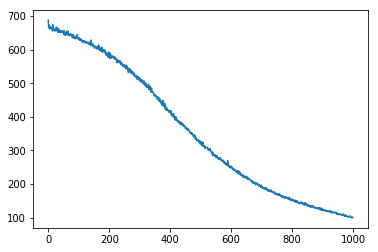

In [35]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.show()

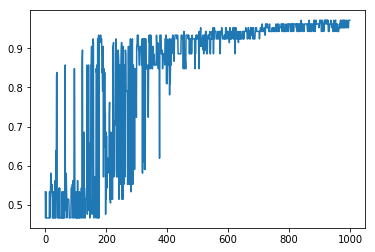

In [36]:
plt.plot(all_accuracies)
plt.show()

### testing

In [37]:
all_preds = []
dy.renew_cg()
for i in range(testX.shape[0]):
    x = np.expand_dims(testX[i], axis=0)
    pred = forward_pass(x)
    all_preds.append(pred.value())

Not surpisingly, the model now learns how to distinguish different documents, and so the predictions range all over.

In [38]:
print(all_preds)

[0.9938002824783325, 0.031892552971839905, 0.019997594878077507, 0.9434055685997009, 0.09757977724075317, 0.0856943354010582, 0.14299167692661285, 0.9841702580451965, 0.9986687898635864, 0.97889244556427, 0.8899160623550415, 0.970642626285553, 0.9784659147262573, 0.9923116564750671, 0.09165816009044647, 0.05546952784061432, 0.9972788095474243, 0.5981377959251404, 0.019594930112361908, 0.15931999683380127, 0.016070013865828514, 0.14317043125629425, 0.0763273686170578, 0.9200121760368347, 0.6172536015510559, 0.9742691516876221, 0.033562071621418, 0.055378735065460205, 0.049312010407447815, 0.943130373954773, 0.03879440575838089, 0.00013812481483910233, 0.03762486204504967, 0.021258540451526642, 0.050125788897275925, 0.9738250970840454, 0.6780632138252258, 0.10629286617040634, 0.3953075110912323, 0.9754804968833923, 0.015997380018234253, 0.9115917086601257, 0.030291849747300148, 0.9801983833312988, 0.3217942416667938, 0.8202344179153442, 0.01976328156888485, 0.046175915747880936, 0.895888

And our accuracy is fantastic!

In [39]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
accuracy

0.9714285714285714